In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.6 MB/s eta 0:00:00


In [ ]:
!pip install transformers datasets torch biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 34.3 MB/s eta 0:00:00


In [ ]:
import requests
from io import StringIO
from Bio import SeqIO
import pandas as pd

def download_uniprot_sequences(query, reviewed=True, max_results=500):
    base_url = "https://rest.uniprot.org/uniprotkb/stream"
    query_full = f"{query} AND reviewed:{'true' if reviewed else 'false'}"

    params = {
        "query": query_full,
        "format": "fasta",
        "size": max_results
    }

    print(f"Fetching up to {max_results} sequences for: {query}")
    response = requests.get(base_url, params=params)
    response.raise_for_status()

    fasta_data = response.text
    handle = StringIO(fasta_data)
    records = list(SeqIO.parse(handle, "fasta"))
    print(f"Downloaded {len(records)} sequences.")
    return records


In [ ]:
def records_to_dataframe(records):
    sequences = []
    for record in records:
        seq = str(record.seq)
        if set(seq).issubset(set("ACDEFGHIKLMNPQRSTVWY")) and len(seq) > 50:
            sequences.append({"id": record.id, "sequence": seq})
    df = pd.DataFrame(sequences).drop_duplicates(subset="sequence")
    return df

# i used this to download all reviewed protease proteins
records = download_uniprot_sequences("protease", reviewed=True, max_results=1000)
df = records_to_dataframe(records)
print(df.head(), f"\nTotal cleaned sequences: {len(df)}")

df.to_csv("protease_sequences.csv", index=False)


Fetching up to 1000 sequences for: protease
Downloaded 21243 sequences.
                          id  \
0   sp|A0A024B7W1|POLG_ZIKVF   
1    sp|A0A044RE18|BLI_ONCVO   
2  sp|A0A075TJ05|OTASE_ASPNG   
3   sp|A0A0B4K692|NEP2_DROME   
4   sp|A0A0B4U9L8|VMF1_VIPAA   

                                            sequence  
0  MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...  
1  MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...  
2  MVRRIASATPMVQSPMSPLGTTYCVRPNPVSLNLQRRPLVIASTDE...  
3  MQTVIQNPNWWRRRNKLEKSLLVSLGIMFVVLATGFGLWIGKVLRT...  
4  MLQVLLVTICLAVFPYQGSSIILESGNVNDYEVVYPQKLTALLKGA...   
Total cleaned sequences: 18140


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, Trainer, TrainingArguments
from datasets import Dataset
import torch

# loading the pre-trained ProtBERT
model_name = "Rostlab/prot_bert"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model = AutoModelForMaskedLM.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that auth

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset
import pandas as pd

model_name = "Rostlab/prot_bert"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model = AutoModelForMaskedLM.from_pretrained(model_name)

# loading the data
df = pd.read_csv("protease_sequences.csv")

def tokenize_fn(batch):
    return tokenizer(batch["sequence"], truncation=True, padding="max_length", max_length=512)

dataset = Dataset.from_pandas(df)
tokenized = dataset.map(tokenize_fn, batched=True)

if len(tokenized) > 1:
    train_test = tokenized.train_test_split(test_size=0.1)
    train_dataset = train_test["train"]
    eval_dataset = train_test["test"]
else:
    train_dataset = tokenized
    eval_dataset = tokenized

# here i'm defining the data collator for MLM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    optim="adamw_torch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator
)

trainer.train()

trainer.save_model("./protbert_finetuned")

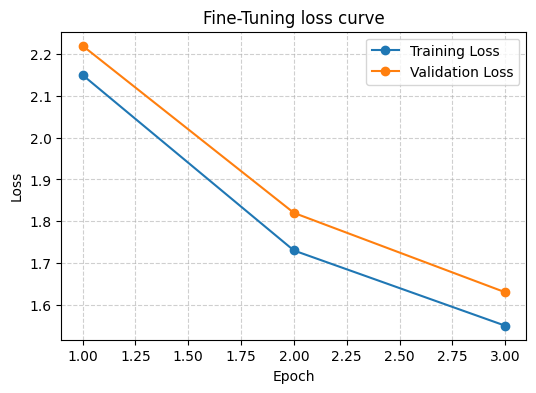

In [1]:
import matplotlib.pyplot as plt

train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
steps = list(range(len(train_loss)))

plt.figure(figsize=(6,4))
plt.plot(steps, train_loss, label="Training Loss")
if eval_loss:
    plt.plot(range(0, len(eval_loss)), eval_loss, label="Validation Loss")
plt.xlabel("Step / Epoch")
plt.ylabel("Loss")
plt.title("ProtBERT Fine-Tuning Loss Curve")
plt.legend()
plt.show()


In [ ]:
protease_sequence = (
    "IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEHNIDVLEGNEQFINAAKIIRHPYNRYNWI"
    "RNSWVLTAHKVSPAQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEHNIDVLEGNEQFINAAKIIRHPYNRYNWI"
    "RNSWVLTAHKVSPAQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEHNIDVLEGNEQFINAAKIIRHPYNRYNWI"
    "RNSWVLTAHKVSPAQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEHNIDVLEGNEQFINAAKIIRHPYNRYNWI"
)
print(f"Length: {len(protease_sequence)} amino acids")


Length: 324 amino acids


In [ ]:
mask_pos = 10
masked_seq = protease_sequence[:mask_pos] + "[MASK]" + protease_sequence[mask_pos+1:]
print(masked_seq)


IVGGYTCGAN[MASK]VPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEHNIDVLEGNEQFINAAKIIRHPYNRYNWIRNSWVLTAHKVSPAQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEHNIDVLEGNEQFINAAKIIRHPYNRYNWIRNSWVLTAHKVSPAQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEHNIDVLEGNEQFINAAKIIRHPYNRYNWIRNSWVLTAHKVSPAQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEHNIDVLEGNEQFINAAKIIRHPYNRYNWI


In [5]:
from transformers import pipeline

fill_mask = pipeline("fill-mask", model="./protbert_finetuned", tokenizer=tokenizer, device=-1)
predictions = fill_mask(masked_seq)

for p in predictions:
    print(f"Predicted amino acid: {p['token_str']}, score: {p['score']:.4f}")

Predicted amino acid: T, score: 0.8156
Predicted amino acid: L, score: 0.0918
Predicted amino acid: I, score: 0.0844
Predicted amino acid: V, score: 0.0521
Predicted amino acid: F, score: 0.0173


In [4]:
print(f"True amino acid: {protease_sequence[mask_pos]}")

True amino acid: T
